<a href="https://colab.research.google.com/github/mhyubr/Sentiment-Analysis-Booster-Vaccine-Research/blob/main/RisetSentimentAnalysis_BoosterVaccine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
!pip install Sastrawi
!pip install swifter
!pip install emoji
import pandas as pd
import numpy as np
import re
import emoji
import string
import gspread
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from sklearn.utils import resample
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 4.7 MB/s 
     |████████████████████████████████| 281 kB 65.5 MB/s 
     |████████████████████████████████| 1.6 MB 54.0 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=da7d1adf564adc04d77b7f94e0d52a6b4c2540ab21443a1ebe112b50583ba915
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.7 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=63e577c5b1816b52ebcb965615917ec24cf1a4621cd42870031a1a5890160d89
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
twitter_data = pd.read_excel('/content/drive/MyDrive/Data Science/Dataset/BoosterDatasetWithLabel.xlsx')

In [ ]:
twitter_data.head()

,Unnamed: 0,label,texts
0,0,neutral,Kimia Farma sebut masyarakat sudah bisa dapatk...
1,1,neutral,Hari2 kes keluar hari2 la org request lockdown...
2,2,neutral,@Bandung_Dinkes info vaksin booster buat lansi...
3,3,positive,"RT @incitu: Banyak nakes di RS yg positif, bai..."
4,4,neutral,"@yourpetsfess Vaksin dr awal, tp biasanya lang..."


In [ ]:
twitter_data.shape

(7741, 3)

In [ ]:
twitter_data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# twitter_data = twitter_data[twitter_data['label'] != 'neutral']

In [ ]:
twitter_data.head(1)

,label,texts
0,neutral,Kimia Farma sebut masyarakat sudah bisa dapatk...


In [ ]:
twitter_data['label'].value_counts()

neutral     5500
positive    1480
negative     761
Name: label, dtype: int64

# EDA

In [ ]:
twitter_data.describe()

,label,texts
count,7741,7741
unique,3,7733
top,neutral,RT @unknownnip: Abis d vaksin booster ko tanga...
freq,5500,3


In [ ]:
twitter_data['texts'].describe()

count                                                  7741
unique                                                 7733
top       RT @unknownnip: Abis d vaksin booster ko tanga...
freq                                                      3
Name: texts, dtype: object

In [ ]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7741 entries, 0 to 7740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7741 non-null   object
 1   texts   7741 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [ ]:
twitter_data.groupby(['label']).count()

,texts
label,
negative,761
neutral,5500
positive,1480


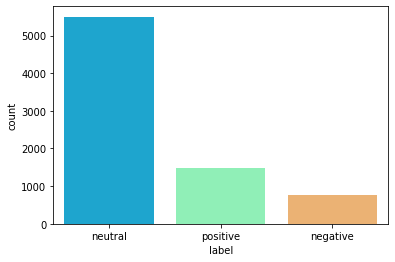

In [ ]:
sns.countplot(x='label', data=twitter_data, palette='rainbow')

In [ ]:
twitter_data['label'].value_counts()

neutral     5500
positive    1480
negative     761
Name: label, dtype: int64

In [ ]:
twitter_data['text_length'] = twitter_data['texts'].apply(len)

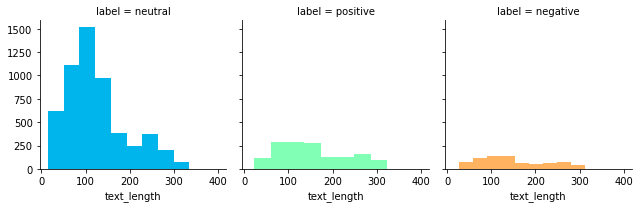

In [ ]:
g = sns.FacetGrid(twitter_data, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

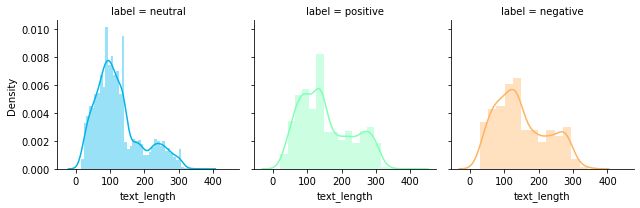

In [ ]:
g = sns.FacetGrid(twitter_data, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

In [ ]:
twitter_data.head(2)

,label,texts,text_length
0,neutral,Kimia Farma sebut masyarakat sudah bisa dapatk...,97
1,neutral,Hari2 kes keluar hari2 la org request lockdown...,278


In [ ]:
twitter_data.text_length.describe()

count    7741.000000
mean      131.132799
std        71.293015
min        15.000000
25%        80.000000
50%       113.000000
75%       169.000000
max       399.000000
Name: text_length, dtype: float64

In [ ]:
twitter_data.dtypes

label          object
texts          object
text_length     int64
dtype: object

In [ ]:
twitter_data[(twitter_data['text_length'] >= 100) & (twitter_data['text_length'] <= 150)]

,label,texts,text_length
3,positive,"RT @incitu: Banyak nakes di RS yg positif, bai...",140
6,neutral,"Terus Gencarkan Vaksinasi Booster, Dinkes Kabu...",113
7,positive,RT @mas_prasetiyo: Studi kasus: Perkembangan c...,140
8,neutral,Bagaimana cara mendapatkan booster dengan vaks...,126
10,negative,First time pake koyo di seumur hidup gw .. geg...,123
...,...,...,...
7727,neutral,"Kunci Mudik Sehat dan Aman, Jangan Lupa Vaksin...",130
7728,neutral,"Kunci Mudik Sehat dan Aman, Jangan Lupa Vaksin...",130
7729,neutral,"Kunci Mudik Sehat dan Aman, Jangan Lupa Vaksin...",130
7730,neutral,"Kunci Mudik Sehat dan Aman, Jangan Lupa Vaksin...",130


In [ ]:
len(twitter_data[(twitter_data['text_length'] >= 100) & (twitter_data['text_length'] <= 150)])

2464

In [ ]:
# twitter_data['text_length'].unique()

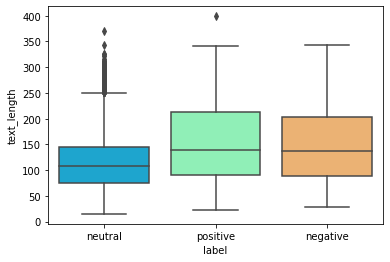

In [ ]:
sns.boxplot(x='label',y='text_length',data=twitter_data,palette='rainbow')

# Distribution Preprocessing

## Missing Value & Duplicate handling

In [ ]:
twitter_data.dropna(subset = ["label"], axis=0, inplace=True)

In [ ]:
twitter_data = twitter_data.drop_duplicates()

In [ ]:
twitter_data['label'].value_counts()

neutral     5494
positive    1479
negative     760
Name: label, dtype: int64

In [ ]:
twitter_data['text_real'] = twitter_data.texts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Outliers Handling

In [ ]:
Q1 = twitter_data['text_length'].quantile(0.25)
Q3 = twitter_data['text_length'].quantile(0.75)
IQR = Q3 - Q1

twitter_data = twitter_data[~((twitter_data['text_length'] < (Q1-1.5*IQR)) | (twitter_data['text_length'] > (Q3+1.5*IQR)))]

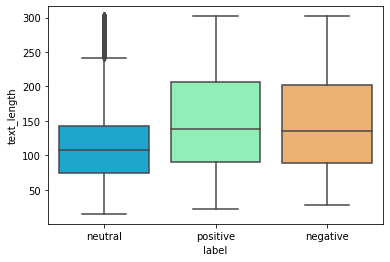

In [ ]:
sns.boxplot(x='label',y='text_length',data=twitter_data,palette='rainbow')

### Neutral

In [ ]:
neutral = twitter_data[twitter_data['label'] ==  'neutral']
len(neutral)

5450

In [ ]:
Q1 = twitter_data[twitter_data['label'] == 'neutral']['text_length'].quantile(0.25)
Q3 = twitter_data[twitter_data['label'] == 'neutral']['text_length'].quantile(0.75)
IQR = Q3 - Q1

twitter_data = twitter_data[~((twitter_data['text_length'] < (Q1-1.5*IQR)) | (twitter_data['text_length'] > (Q3+1.5*IQR)))]

In [ ]:
# neutral_data = twitter_data[twitter_data['label'] == 'neutral']
# neutral_data.label.unique()

In [ ]:
# neutral_no_outlier = neutral_data[~((neutral_data['text_length'] < (Q1-1.5*IQR)) | (neutral_data['text_length'] > (Q3+1.5*IQR)))]

In [ ]:
# sns.boxplot(x='label', y='text_length', data=neutral_no_outlier)

In [ ]:
# neutral_no_outlier.shape

In [ ]:
# sns.boxplot(x='label',y='text_length', data=twitter_data, palette='rainbow')

### Delete & Merge Neutral Data After Delete Outlier

In [ ]:
# twitter_data['label'].unique()

In [ ]:
# twitter_data = twitter_data[~(twitter_data.label == 'neutral')]

In [ ]:
# twitter_data['label'].unique()

In [ ]:
# twitter_data.columns

In [ ]:
# neutral_no_outlier.columns

In [ ]:
# twitter_data = pd.concat([twitter_data, neutral_no_outlier])

In [ ]:
# twitter_data.columns

In [ ]:
# twitter_data['label'].unique()

In [ ]:
# twitter_data.head()

In [ ]:
# twitter_data.shape

## Show Final Distrubution & Outlier

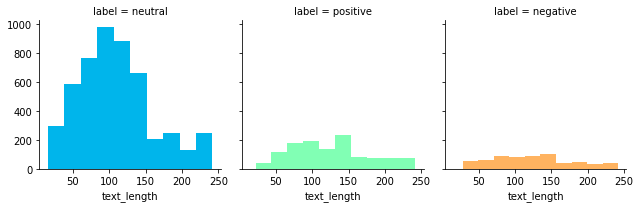

In [ ]:
g = sns.FacetGrid(twitter_data, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

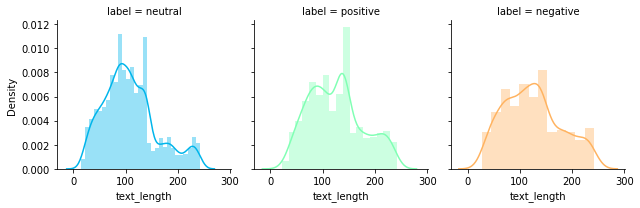

In [ ]:
g = sns.FacetGrid(twitter_data, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

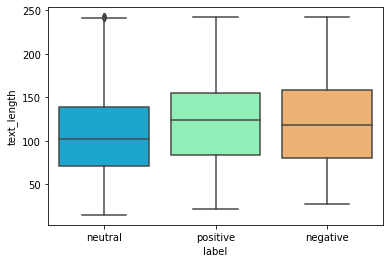

In [ ]:
sns.boxplot(x='label',y='text_length', data=twitter_data, palette='rainbow')

## Imbalance Class Handling

In [ ]:
twitter_data.label.value_counts()

neutral     5015
positive    1205
negative     637
Name: label, dtype: int64

In [ ]:
# Resample data twitter
twitter_neutral = resample(twitter_data[twitter_data['label'] == 'neutral'], 
                                 replace=True,    
                                 n_samples=630,    
                                 random_state=123)

twitter_positive = resample(twitter_data[twitter_data['label'] == 'positive'], 
                                 replace=True,    
                                 n_samples=630,    
                                 random_state=123) 

twitter_negative = resample(twitter_data[twitter_data['label'] == 'negative'], 
                                 replace=True,    
                                 n_samples=630,    
                                 random_state=123) 

# Gabung ulang
twitter_data = pd.concat([twitter_neutral, twitter_positive, twitter_negative])
 
twitter_data.label.value_counts()

neutral     630
positive    630
negative    630
Name: label, dtype: int64

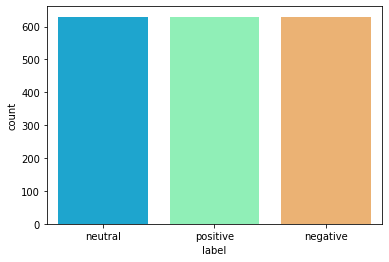

In [ ]:
sns.countplot(x='label', data=twitter_data, palette='rainbow')

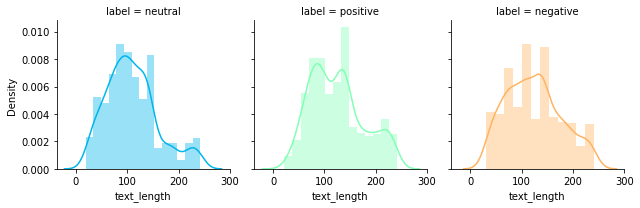

In [ ]:
g = sns.FacetGrid(twitter_data, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

# Features Engeneering

## Remove Link, Hashtag, Mention

In [ ]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt) #Remove mentions
    txt = re.sub(r'#[A-Za-z0-9_]+', '', txt) #Remove hashtags
    txt = re.sub(r'RT ', '', txt) #Remove retweets
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt) #Remove urls
    return txt

In [ ]:
def stripEmoji(txt):
  txt = re.sub(emoji.get_emoji_regexp(), r'', txt)
  return txt

In [ ]:
# twitter_data['texts'] = twitter_data['texts'].apply(cleanUpTweet)
# twitter_data['texts'] = twitter_data['texts'].apply(stripEmoji)

## Remove HTML Char

In [ ]:
def removeHTMLChar(text):
    text = ' '.join(re.sub("([&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text

In [ ]:
twitter_data['texts'] = twitter_data['texts'].apply(removeHTMLChar)

## Remove Number

In [ ]:
# def removeNumbers(text):
#     """ Removes integers """
#     text = ''.join([i for i in text if not i.isdigit()])         
#     return text

In [ ]:
# twitter_data['texts'] = twitter_data['texts'].apply(removeNumbers)

## Remove Punctuation

In [ ]:
def remove_punctuation(txt):
  txt = re.sub(r'[^\w\s]', ' ', txt)
  return txt
    # return text.translate(str.maketrans("","",string.punctuation))

In [ ]:
twitter_data['texts'] = twitter_data['texts'].apply(remove_punctuation)

In [ ]:
twitter_data['texts'].iloc[176]

'Ayo vaksin untuk menciptakan herd immunity terhadap virus covid 19    booster  lebaran'

In [ ]:
twitter_data.head()

,label,texts,text_length,text_real
5511,neutral,Ada yang bisa share pengalaman vaksin booster ...,59,Ada yang bisa share pengalaman vaksin booster ...
5321,neutral,Vaksin Booster Mudik Aman Prokes Bentuk Ibadah,71,Vaksin Booster Mudik Aman. Prokes Bentuk Ibada...
2156,neutral,nakesbibi open CT syaratnya harus udah vaksin...,55,@nakesbibi open CT syaratnya harus udah vaksin...
6275,neutral,beyoumw Selamat malam dan mohon maaf baru ter...,188,@beyoumw Selamat malam dan mohon maaf baru ter...
2571,neutral,Kamis 3 2 Keluarga Besar Kementerian Keuanga...,199,Kamis (3/2) Keluarga Besar Kementerian Keuanga...


## Remove Whitespace

In [ ]:
def remove_whitespace_LT(text):
    return text.strip()

In [ ]:
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

In [ ]:
def spell(word):
    if re.search(r'([a-zA-Z])\1{2,}', word):
        rword = re.sub(r'([a-zA-Z])\1{2,}','\\1', word)
        return rword
    else:
        return word

In [ ]:
twitter_data['texts'] = twitter_data['texts'].apply(remove_whitespace_LT)
twitter_data['texts'] = twitter_data['texts'].apply(remove_whitespace_multiple)
twitter_data['texts'] = twitter_data['texts'].apply(spell)

## To Lowercase

In [ ]:
twitter_data["texts"] = twitter_data["texts"].apply(lambda item: str(item).lower())

In [ ]:
# twitter_data.to_excel("VaksinasiBoosterDatasetWithLabel.xlsx")

In [ ]:
# Remove Label Netral
# twitter_data = twitter_data[twitter_data.label != 'neutral']

## Remove Special Character

In [ ]:
def remove_text_special(text):
    # hapus tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # hapus non ASCII (emot, bahasa china dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # hapus mention, link, hashtag
    # text = text.replace("rt", "") # revisi
    text = ' '.join(re.sub("([@#&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove URL 
    return text.replace("http://", " ").replace("https://", " ")

In [ ]:
twitter_data['texts'] = twitter_data.texts.astype('str')                
twitter_data['texts'] = twitter_data['texts'].apply(remove_text_special)

In [ ]:
twitter_data['texts'].iloc[150]

'mau mudik tak perlu panik pastikan kamu sudah vaksin booster update perjalanan domestik dosis 3 booster tidak wajib menunjukan negatif test covid 19 polripresisi polrestebo tebotoday'

# Tokenize

In [ ]:
from nltk.tokenize import word_tokenize 

In [ ]:
def word_tokenize_wrapper(text):
    return word_tokenize(text)
    
def tokenize(word):
  word = word.split(" ")
  return word

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
twitter_data['text_tokens'] = twitter_data['texts'].apply(word_tokenize_wrapper)

# Count Word

In [ ]:
from collections import defaultdict
word_count = defaultdict(int)
for tokens in twitter_data["text_tokens"]:
    for token in tokens:
       word_count[token] += 1

In [ ]:
word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(10)

,key,count
5,vaksin,2155
6,booster,1927
23,dan,467
11,prokes,339
38,di,322
385,yg,252
9,mudik,241
10,aman,237
33,ini,237
1,yang,198


# Stopword Removal

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah'])

txt_stopword = pd.read_csv("/content/drive/MyDrive/Data Science/Dataset/stopwords.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
twitter_data['text_tokens_WSW'] = twitter_data['text_tokens'].apply(stopwords_removal) 

# Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

In [ ]:
df_normalized = pd.DataFrame(twitter_data['label'])
df_normalized['text'] = twitter_data['texts']

In [ ]:
normalizad_word = df_normalized

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]  

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

twitter_data['text_normalized'] = twitter_data['text_tokens_WSW'].apply(normalized_term)


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in twitter_data['text_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

twitter_data['text_tokens_stemmed'] = twitter_data['text_normalized'].swifter.apply(get_stemmed_term)

4113
------------------------
pengalaman : alam
vaksin : vaksin
booster : booster
pake : pake
modern4 : modern4
mudik : mudik
aman : aman
prokes : prokes
bentuk : bentuk
ibadah : ibadah
nakesbibi : nakesbibi
open : open
ct : ct
syaratnya : syarat
beyoumw : beyoumw
selamat : selamat
malam : malam
maaf : maaf
terbalaskan : balas
padatnya : padat
antrean : antre
interaksi : interaksi
tersedia : sedia
layanan : layan
stasiun : stasiun
surabaya : surabaya
pasar : pasar
turi : turi
trims : trims
kamis : kamis
3 : 3
2 : 2
keluarga : keluarga
kementerian : menteri
keuangan : uang
cirebon : cirebon
bertempat : tempat
aula : aula
kpp : kpp
pratama : pratama
beacukaimakinbaik : beacukaimakinbaik
bundaskies_95 : bundaskies 95
kirain : kirain
cita2nya : cita2nya
janji : janji
ketiduran : tidur
sasar : sasar
pedagang : dagang
pengunjung : unjung
dewi : dewi
sri : sri
pemudik : mudik
pos : pos
pengamanan : aman
lebaran : lebaran
batubulan : batubulan
mengadakan : ada
kemenkesri : kemenkesri
wna : wna

/usr/local/lib/python3.7/dist-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


Pandas Apply:   0%|          | 0/1890 [00:00<?, ?it/s]

# Merge

In [ ]:
def merge_again(text):
    return ' '.join(text)

In [ ]:
twitter_data['done_text'] = twitter_data['text_tokens_stemmed'].apply(merge_again)

In [ ]:
for i in range(51):
  print(twitter_data['done_text'].iloc[i])

alam vaksin booster pake modern4
vaksin booster mudik aman prokes bentuk ibadah
nakesbibi open ct syarat vaksin booster
beyoumw selamat malam maaf balas padat antre interaksi sedia layan vaksin booster stasiun surabaya pasar turi trims
kamis 3 2 keluarga menteri uang cirebon vaksin booster tempat aula kpp pratama cirebon beacukaimakinbaik beacukaimakinbaik
bundaskies 95 kirain vaksin booster
cita2nya janji vaksin booster tidur
sasar dagang unjung pasar dewi sri mudik pos aman lebaran batubulan ada vaksin booster
kemenkesri vaksin booster wna sedia vaksin dosis negara asal
akangabdul90 keren nihh protokoler sehat akang vaksin booster tiga recommended
aulmaulidiana mudik syarat vaksin booster                  
tekan sebar covid 19 menteri johnny vaksin booster aman tunda prokes kendor
vaksin booster jujur tuju gua vaksin booster kaga antigen kemana2 ribet
gebrak gibran vaksin booster beli minyak goreng murah
video tindak zombie suntik vaksin booster
harhaarr tweeps warga jakarta vaksin b

# Modelling

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## Setup TFIDF and CountVectorizer

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
tfid = TfidfVectorizer(
    min_df = 3,
    max_df = 0.10,
    ngram_range = (1,2)
)

In [ ]:
count_vect = CountVectorizer(
    min_df = 3,
    max_df = 0.10,
    ngram_range = (1,2)
)

In [ ]:
tfid_result = tfid.fit_transform(twitter_data["texts"]).toarray() #
tfid_df = pd.DataFrame(tfid_result, columns = tfid.get_feature_names())
tfid_df.columns = ["word_" + str(x) for x in tfid_df.columns]
tfid_df.index = twitter_data.index

In [ ]:
cvzr_result = count_vect.fit_transform(twitter_data["texts"]).toarray() #
cvzr_df = pd.DataFrame(cvzr_result, columns = count_vect.get_feature_names())
cvzr_df.columns = ["word_" + str(x) for x in cvzr_df.columns]
cvzr_df.index = twitter_data.index

In [ ]:
cvzr_df.columns

Index(['word_00', 'word_00 wib', 'word_000', 'word_02', 'word_02 04',
       'word_02 2022', 'word_04', 'word_04 2022', 'word_05', 'word_05 04',
       ...
       'word_yok', 'word_you', 'word_you for', 'word_youtube', 'word_yuk',
       'word_yuk vaksin', 'word_yukz', 'word_yukz pada', 'word_zeneca',
       'word_zombie'],
      dtype='object', length=3769)

## SVM Model

### 80 : 20

In [ ]:
# extract the labels from the train data
y = twitter_data.label.values
# use 80% for the training and 20% for the test
x_train, x_test, y_train, y_test = train_test_split(twitter_data.texts.values, y, #
stratify=y,
random_state=1,
test_size=0.2, shuffle=True)

### 70 : 30

In [ ]:
# # extract the labels from the train data
# y = twitter_data.label.values
# # use 70% for the training and 30% for the test
# x_train, x_test, y_train, y_test = train_test_split(twitter_data.texts.values, y, #
# stratify=y,
# random_state=1,
# test_size=0.3, shuffle=True)

In [ ]:
# initializing the countvectorizer
vectorizer = CountVectorizer()
# tokenize and make the document into a matrix
document_term_matrix = vectorizer.fit_transform(twitter_data['texts']) #
# check the result
df_baru = pd.DataFrame(document_term_matrix.toarray(), columns = vectorizer.get_feature_names())

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True)
# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(x_train) + list(x_test))
# transform documents to document-term matrix
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [ ]:
from sklearn import svm
# classify using support vector classifier
svm = svm.SVC(kernel = 'linear', probability=True)
# fit the SVC model based on the given training data
prob = svm.fit(x_train_vec, y_train).predict_proba(x_test_vec)
# perform classification and prediction on samples in x_test
y_pred_svm = svm.predict(x_test_vec)

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_svm)
print(conf_mat)
print(classification_report(y_test, y_pred_svm, digits = 4))

print("Accuracy score for SVM is: ", accuracy_score(y_test, y_pred_svm) * 100, '%')

[[105  15   6]
 [ 12 101  13]
 [  8  23  95]]
              precision    recall  f1-score   support

    negative     0.8400    0.8333    0.8367       126
     neutral     0.7266    0.8016    0.7623       126
    positive     0.8333    0.7540    0.7917       126

    accuracy                         0.7963       378
   macro avg     0.8000    0.7963    0.7969       378
weighted avg     0.8000    0.7963    0.7969       378

Accuracy score for SVM is:  79.62962962962963 %


Text(0.5, 1.0, '\nSVM Model\n')

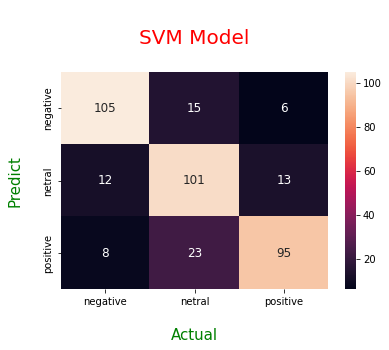

In [ ]:
label = ['negative','netral','positive']
sns.heatmap(
    conf_mat, 
    xticklabels=label, 
    yticklabels=label, 
    fmt='d', 
    annot_kws={'size':12},
    annot = True
    )
plt.xlabel('\nActual', fontsize=15, color='g')
plt.ylabel('Predict\n', fontsize=15, color='g')
plt.title('\nSVM Model\n',  fontsize=20, color='red')

## Tunning Parameter

In [ ]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {
    'C' : [1000, 10000, 100000],
    'gamma' : [0.5, 0.05, 0.005],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
    }
 
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
 
# fitting the model for grid search
grid.fit(x_train_vec, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ..C=1000, gamma=0.5, kernel=linear;, score=0.736 total time=   0.3s
[CV 2/5] END ..C=1000, gamma=0.5, kernel=linear;, score=0.772 total time=   0.3s
[CV 3/5] END ..C=1000, gamma=0.5, kernel=linear;, score=0.755 total time=   0.3s
[CV 4/5] END ..C=1000, gamma=0.5, kernel=linear;, score=0.735 total time=   0.3s
[CV 5/5] END ..C=1000, gamma=0.5, kernel=linear;, score=0.768 total time=   0.3s
[CV 1/5] END ....C=1000, gamma=0.5, kernel=poly;, score=0.703 total time=   0.3s
[CV 2/5] END ....C=1000, gamma=0.5, kernel=poly;, score=0.739 total time=   0.3s
[CV 3/5] END ....C=1000, gamma=0.5, kernel=poly;, score=0.705 total time=   0.3s
[CV 4/5] END ....C=1000, gamma=0.5, kernel=poly;, score=0.679 total time=   0.3s
[CV 5/5] END ....C=1000, gamma=0.5, kernel=poly;, score=0.709 total time=   0.3s
[CV 1/5] END .....C=1000, gamma=0.5, kernel=rbf;, score=0.683 total time=   0.3s
[CV 2/5] END .....C=1000, gamma=0.5, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1000, 10000, 100000],
                         'gamma': [0.5, 0.05, 0.005],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.05, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.05)


In [ ]:
grid_predictions = grid.predict(x_test_vec)

# print classification report
print(classification_report(y_test, grid_predictions))
print("Accuracy score for SVM is: ", accuracy_score(y_test, grid_predictions) * 100, '%')

              precision    recall  f1-score   support

    negative       0.84      0.84      0.84       126
     neutral       0.76      0.79      0.78       126
    positive       0.81      0.78      0.79       126

    accuracy                           0.80       378
   macro avg       0.80      0.80      0.80       378
weighted avg       0.80      0.80      0.80       378

Accuracy score for SVM is:  80.42328042328042 %


## SVM Model - After Tune

In [ ]:
from sklearn import svm
# classify using support vector classifier
svm = svm.SVC(
    C=grid.best_params_['C'], 
    gamma=grid.best_params_['gamma'], 
    kernel=grid.best_params_['kernel'], 
    probability=True)
# fit the SVC model based on the given training data
prob = svm.fit(x_train_vec, y_train).predict_proba(x_test_vec)
# perform classification and prediction on samples in x_test
y_pred_svm = svm.predict(x_test_vec)

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_svm)
print(conf_mat)
print(classification_report(y_test, y_pred_svm, digits = 4))

print("Accuracy score for SVM is: ", accuracy_score(y_test, y_pred_svm) * 100, '%')

[[106  11   9]
 [ 12 100  14]
 [  8  20  98]]
              precision    recall  f1-score   support

    negative     0.8413    0.8413    0.8413       126
     neutral     0.7634    0.7937    0.7782       126
    positive     0.8099    0.7778    0.7935       126

    accuracy                         0.8042       378
   macro avg     0.8048    0.8042    0.8043       378
weighted avg     0.8048    0.8042    0.8043       378

Accuracy score for SVM is:  80.42328042328042 %


Text(0.5, 1.0, '\nSVM Model After Tune\n')

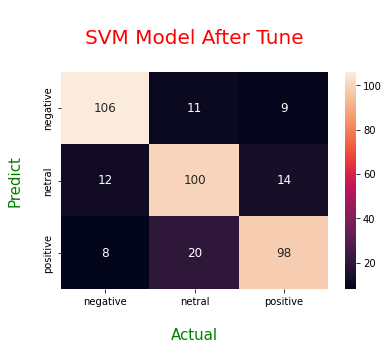

In [ ]:
label = ['negative','netral','positive']
sns.heatmap(
    conf_mat, 
    xticklabels=label, 
    yticklabels=label, 
    fmt='d', 
    annot_kws={'size':12},
    annot = True
    )
plt.xlabel('\nActual', fontsize=15, color='g')
plt.ylabel('Predict\n', fontsize=15, color='g')
plt.title('\nSVM Model After Tune\n',  fontsize=20, color='red')

## Trying New Data On Model

In [ ]:
test = vectorizer.transform(['habis vaksin booster malah sakit parah'])
svm.predict(test)

array(['negative'], dtype=object)

In [ ]:
test = vectorizer.transform(['barusan lihat berita vaksin booster di berita'])
svm.predict(test)

array(['neutral'], dtype=object)

In [ ]:
test = vectorizer.transform(['vaksin booster sejauh ini masih aman, badan tidak merasakan sakit apapun seperti yang dikatakan orang2'])
svm.predict(test)

array(['positive'], dtype=object)

In [ ]:
test = vectorizer.transform(['malas ahh mau vaksin booster kelamaan ngantrinya'])
svm.predict(test)

array(['neutral'], dtype=object)

In [ ]:
# twitter_data[twitter_data['label'] == 'neutral']['text_real'].to_list()[10:21]

In [ ]:
test = vectorizer.transform(['habis vaksin booster bukannya terhindar dari wabah, malah sering sakit'])
svm.predict(test)

array(['negative'], dtype=object)

In [ ]:
test = vectorizer.transform(['cape banget habis vaksin, mana antriannya juga panjang'])
svm.predict(test)

array(['negative'], dtype=object)

## Model Evaluation

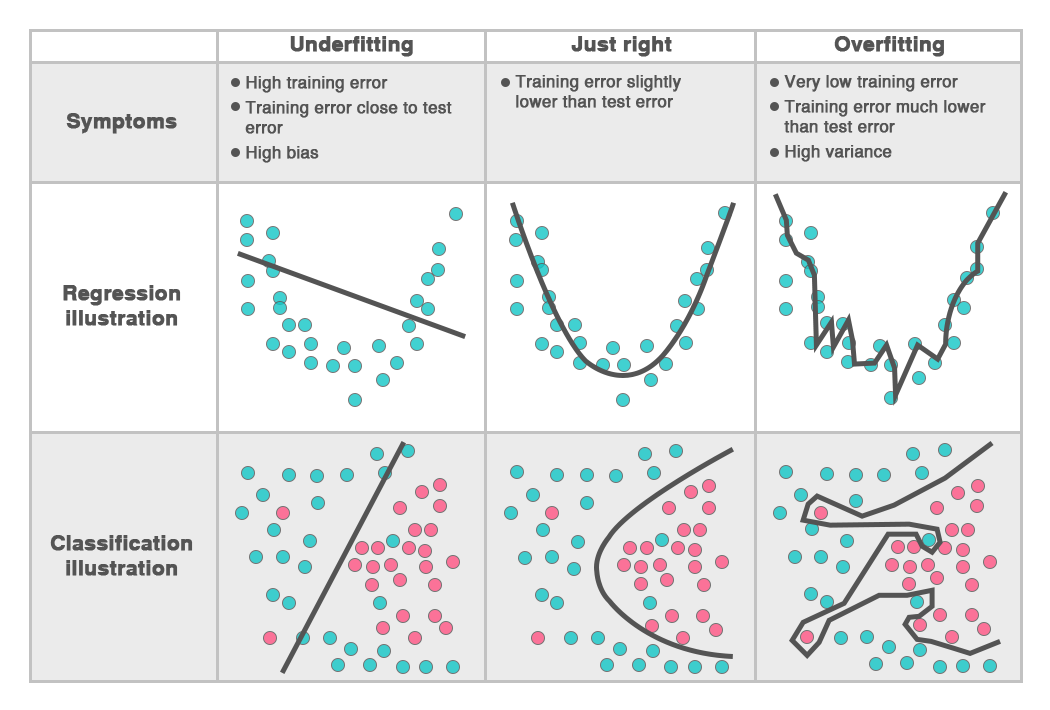

In [ ]:
print('Training Accuracy :', svm.score(x_train_vec, y_train))
print('Testing Accuracy :', svm.score(x_test_vec, y_test))
print('Accuracy Difference :', svm.score(x_train_vec, y_train) - svm.score(x_test_vec, y_test))

Training Accuracy : 0.9966931216931217
Testing Accuracy : 0.8042328042328042
Accuracy Difference : 0.19246031746031755


### Wordcloud

#### Positive

1723


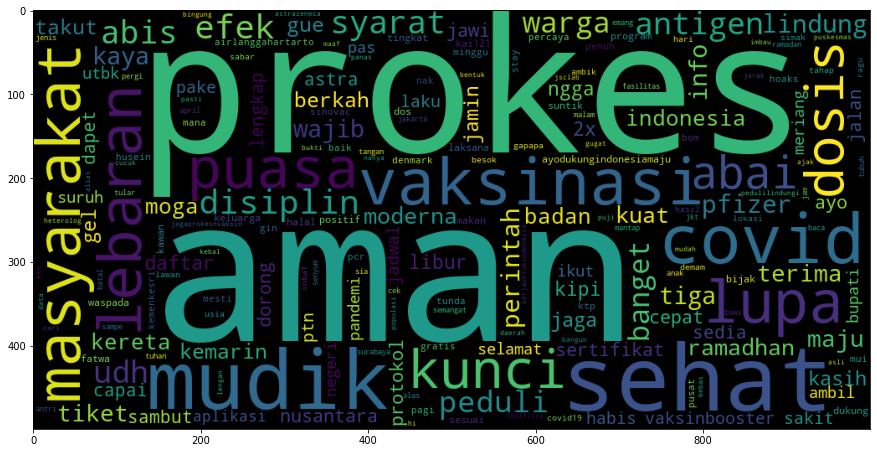

In [ ]:
positive_word = []
for text in twitter_data[twitter_data['label']=='positive']['done_text']:
  for word in text.split():
    if word.isnumeric() == False:
      positive_word.append(word)
x = Counter(positive_word)
{k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}['vaksin']
{k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}['booster']
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
del d['vaksin']
del d['booster']
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

#### Negative

1522


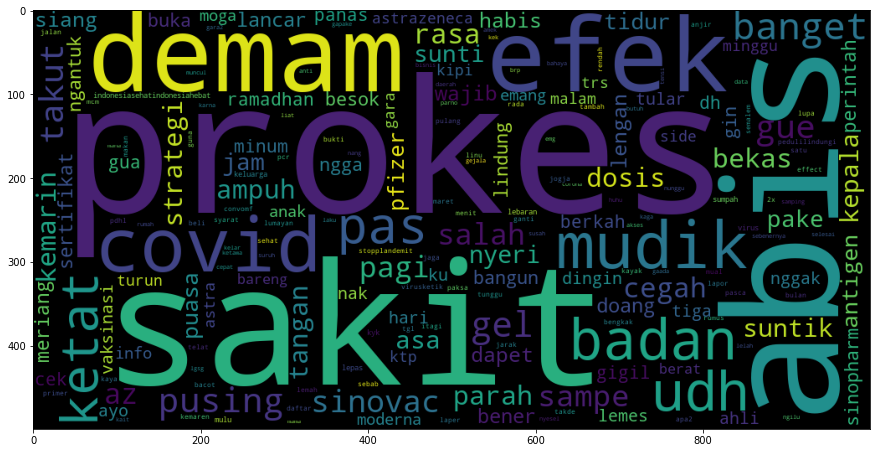

In [ ]:
negative_word = []
for text in twitter_data[twitter_data['label']=='negative']['done_text']:
  for word in text.split():
    if word.isnumeric() == False:
      negative_word.append(word)
x = Counter(negative_word)
{k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}['vaksin']
{k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}['booster']
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
del d['vaksin']
del d['booster']
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

#### Neutral

1614


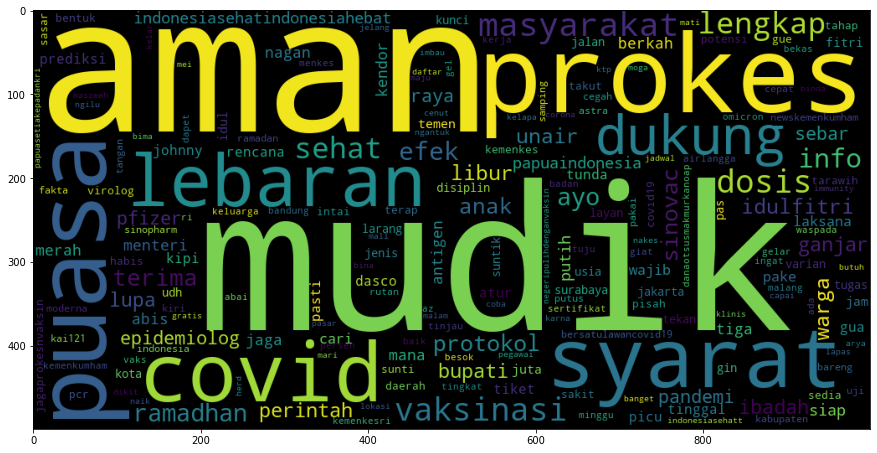

In [ ]:
neutral_word = []
for text in twitter_data[twitter_data['label']=='neutral']['done_text']:
  for word in text.split():
    if word.isnumeric() == False:
      neutral_word.append(word)
x = Counter(neutral_word)
{k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}['vaksin']
{k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}['booster']
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
del d['vaksin']
del d['booster']
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

### Wordcount

#### Positive

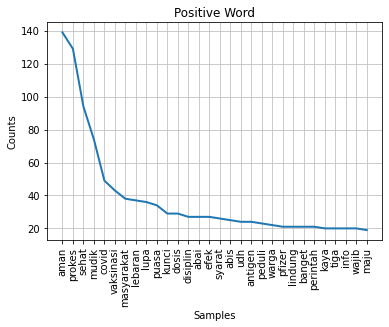

In [ ]:
positive_word = []
for text in twitter_data[twitter_data['label']=='positive']['done_text']:
  for word in text.split():
    if word.isnumeric() == False:
      if word == 'vaksin' or word =='Vaksin' or word == 'booster' or word == 'Booster':
        continue
      else:
        positive_word.append(word)
fdist_filtered = FreqDist(positive_word)
fdist_filtered.plot(30,title='Positive Word')

#### Negative

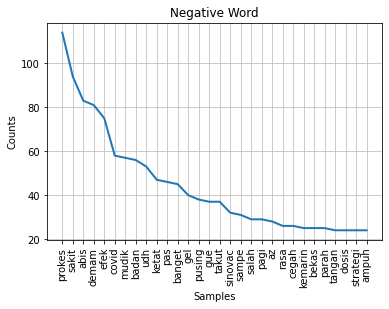

In [ ]:
negative_word = []
for text in twitter_data[twitter_data['label']=='negative']['done_text']:
  for word in text.split():
    if word.isnumeric() == False:
      if word == 'vaksin' or word =='Vaksin' or word == 'booster' or word == 'Booster':
        continue
      else:
        negative_word.append(word)
fdist_filtered = FreqDist(negative_word)
fdist_filtered.plot(30,title='Negative Word')

#### Neutral

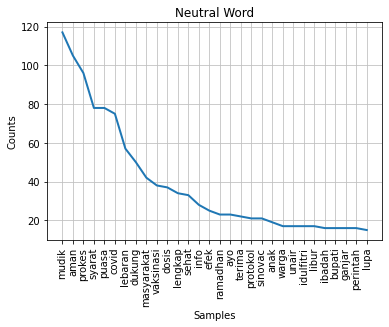

In [ ]:
neutral_word = []
for text in twitter_data[twitter_data['label']=='neutral']['done_text']:
  for word in text.split():
    if word.isnumeric() == False:
      if word == 'vaksin' or word =='Vaksin' or word == 'booster' or word == 'Booster':
        continue
      else:
        neutral_word.append(word)
fdist_filtered = FreqDist(neutral_word)
fdist_filtered.plot(30,title='Neutral Word')

## Model Validation

In [ ]:
val_data = pd.read_csv('/content/drive/MyDrive/RISET SENTIMENT ANALYSIS/Dataset/Data-Validation-Model-NLP-Booster-Vaccine - Sheet1.csv')
val_data.head()

,texts,label
0,habis vaksin booster malah sakit parah,negative
1,"barusan lihat berita vaksin booster di berita,...",neutral
2,"vaksin booster sejauh ini masih aman, badan ti...",positive
3,malas ahh mau vaksin booster kelamaan ngantrin...,negative
4,habis vaksin booster bukannya terhindar dari w...,negative


In [ ]:
val_neutral = resample(val_data[val_data['label'] == 'neutral'], 
                                 replace=True,    
                                 n_samples=10,    
                                 random_state=123)

val_positive = resample(val_data[val_data['label'] == 'positive'], 
                                 replace=True,    
                                 n_samples=10,    
                                 random_state=123) 

val_negative = resample(val_data[val_data['label'] == 'negative'], 
                                 replace=True,    
                                 n_samples=10,    
                                 random_state=123) 

# Gabung ulang
val_data = pd.concat([val_neutral, val_positive, val_negative])
 
val_data.label.value_counts()

neutral     10
positive    10
negative    10
Name: label, dtype: int64

In [ ]:
val_data.label.value_counts()

neutral     10
positive    10
negative    10
Name: label, dtype: int64

In [ ]:
x_val = vectorizer.transform(val_data['texts'])
val_pred = svm.predict(x_val)
val_pred

array(['neutral', 'neutral', 'neutral', 'positive', 'neutral', 'positive',
       'positive', 'negative', 'neutral', 'positive', 'neutral',
       'neutral', 'positive', 'neutral', 'neutral', 'positive',
       'negative', 'positive', 'neutral', 'positive', 'negative',
       'negative', 'negative', 'neutral', 'neutral', 'negative',
       'neutral', 'negative', 'negative', 'neutral'], dtype=object)

In [ ]:
conf_mat = confusion_matrix(val_data['label'], val_pred)
print(conf_mat)
print(classification_report(val_data['label'], val_pred, digits = 4))

print("Accuracy score for SVM is: ", accuracy_score(val_data['label'], val_pred) * 100, '%')

[[6 4 0]
 [1 5 4]
 [1 5 4]]
              precision    recall  f1-score   support

    negative     0.7500    0.6000    0.6667        10
     neutral     0.3571    0.5000    0.4167        10
    positive     0.5000    0.4000    0.4444        10

    accuracy                         0.5000        30
   macro avg     0.5357    0.5000    0.5093        30
weighted avg     0.5357    0.5000    0.5093        30

Accuracy score for SVM is:  50.0 %


## Model Export

Pickle

In [ ]:
import pickle

with open('model_pickle', 'wb') as f:
  pickle.dump(svm,f)

### Import Model

In [ ]:
# with open('model_pickle','rb') as f:
#   mp = pickle.load(f)

In [ ]:
# test = vectorizer.transform(['habis vaksin booster malah sakit parah'])
# mp.predict(test)